https://slideslive.com/38941707/singlestation-earthquake-location-using-deep-neural-networks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

import seisbench
import seisbench.data as sbd
import seisbench.generate as sbg

from tqdm.auto import tqdm

In [2]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
from torch.utils.data import DataLoader

In [3]:
stead = sbd.STEAD(component_order='ZNE')

In [357]:
train, dev, test = stead.train_dev_test()
print(train)
print(dev)
print(test)

STEAD - 1075808 traces
STEAD - 63283 traces
STEAD - 126566 traces


In [358]:
surface_stations = np.load("surface_stations.npy")
surface_stations = np.array(list(set([i[:-4] for i in surface_stations])))

In [359]:
def read_snr(x):
    x = x[1:-1]
    return [float(i) for i in x.split(" ") if i != ""]

https://github.com/smousavi05/Deep-Bays-Loc/blob/main/ENZ_checker.py

In [360]:
MAX_DISTANCE = 60
def filter_data(data):
    data.filter(data.metadata["source_distance_km"].notnull())
    data.filter(data.metadata["source_magnitude"].notnull())
    data.filter(data.metadata["path_back_azimuth_deg"].notnull())
    data.filter(data.metadata["source_distance_km"] <= MAX_DISTANCE)
    data.filter(data.metadata["trace_p_arrival_sample"] >= 20)
    data.filter(data.metadata["source_magnitude"] > 0)
    data.filter(data.metadata["source_magnitude"] < 4)
    data.metadata["trace_snr_db"] = data.metadata["trace_snr_db"].apply(lambda x: np.min(read_snr(x)))
    data.filter(data.metadata["trace_snr_db"] >= 5)
    data.metadata["surface_code"] = data.metadata["station_network_code"] + "_" + data.metadata["station_code"]
    data.filter(np.array([i in surface_stations for i in data.metadata["surface_code"]]))

filter_data(train)
filter_data(dev)
filter_data(test)

/var/folders/g7/l9_hhr256md6lt7yldvmnjjw0000gn/T/ipykernel_77869/2549584681.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  data.filter(np.array([i in surface_stations for i in data.metadata["surface_code"]]))


In [361]:
print(train)
print(dev)
print(test)

STEAD - 183179 traces
STEAD - 10795 traces
STEAD - 21592 traces


In [362]:
def prepare_control(dataset):
    control = []
    for i in range(len(dataset)):
        row = dataset.metadata.iloc[i]
        control_row = {"trace_name": row["trace_name"],
                       "start_sample": row["trace_p_arrival_sample"]-20,
                       "end_sample": row["trace_p_arrival_sample"]+30}
        control.append(control_row)
    return control

train_control = pd.DataFrame(prepare_control(train))
dev_control = pd.DataFrame(prepare_control(dev))
test_control = pd.DataFrame(prepare_control(test))

In [363]:
train_generator = sbg.SteeredGenerator(train, train_control)
dev_generator = sbg.SteeredGenerator(dev, dev_control)
test_generator = sbg.SteeredGenerator(test, test_control)

@test_generator.augmentation
@dev_generator.augmentation
@train_generator.augmentation
def add_augmentation(state_dict):
    state_dict["time"] = (pd.to_datetime(state_dict['X'][1]["trace_start_time"], 
                                         format='%Y-%m-%d %H:%M:%S.%f'
                                        ).timestamp()-pd.to_datetime(state_dict['X'][1]["source_origin_time"], 
                                         format='%Y-%m-%d %H:%M:%S.%f'
                                        ).timestamp()+state_dict['X'][1]["trace_p_arrival_sample"]/100
                          , None)
    state_dict["diff_p_s"] = (state_dict['X'][1]["trace_s_arrival_sample"]-state_dict['X'][1]["trace_p_arrival_sample"], None)
    state_dict["angle"] = (state_dict['X'][1]["path_back_azimuth_deg"], None)
    state_dict["x"] = (np.cos(state_dict['X'][1]["path_back_azimuth_deg"]*2*np.pi/360)*state_dict['X'][1]["source_distance_km"]/MAX_DISTANCE, None)
    state_dict["y"] = (np.sin(state_dict['X'][1]["path_back_azimuth_deg"]*2*np.pi/360)*state_dict['X'][1]["source_distance_km"]/MAX_DISTANCE, None)

train_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))
dev_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))
test_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))

windowlen = 50
train_generator.augmentation(sbg.SteeredWindow(windowlen=windowlen))
dev_generator.augmentation(sbg.SteeredWindow(windowlen=windowlen))
test_generator.augmentation(sbg.SteeredWindow(windowlen=windowlen))

In [568]:
train_loader = DataLoader(train_generator, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_generator, batch_size=len(dev_generator), shuffle=True)
test_loader = DataLoader(test_generator, batch_size=1000, shuffle=False)

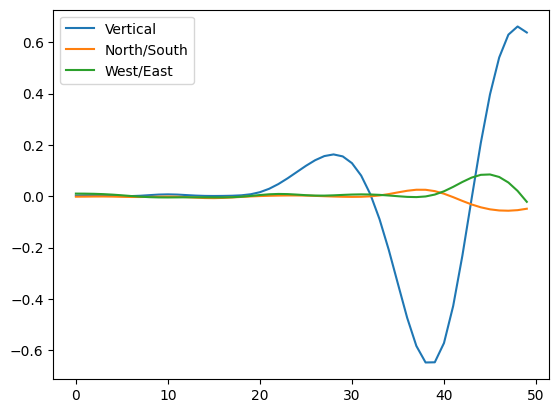

In [569]:
item = 0
plt.plot(train_generator[item]['X'].T)
plt.legend(["Vertical", "North/South", "West/East"])
plt.show()

In [570]:
def loss_fn(model, X, y):
    y_hat = model(X)
    return mx.mean(nn.losses.mse_loss(y_hat, y))

def eval_fn(model, X, y):
    y_hat = model(X)
    return mx.mean((((y[:, 0]-y_hat[:, 0])**2) + ((y[:, 1]-y_hat[:, 1])**2))**0.5)

In [579]:
class CNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c0_0 = nn.Conv1d(in_channels=3, out_channels=6, kernel_size=3, padding=0)
        self.c0_1 = nn.Conv1d(in_channels=6, out_channels=12, kernel_size=3, padding=0)

        #self.pool = nn.AvgPool1d(3)

        self.a0 = nn.Tanh()
        self.l0 = nn.Linear(552+1, 64)
        self.l1 = nn.Linear(64, 2)
        
        self.d0 = nn.Dropout(0.1)
        
    def __call__(self, x):
        x, diff_p_s = x
        
        x = self.d0(self.a0(self.c0_0(x)))
        x = self.d0(self.a0(self.c0_1(x)))
        
        x = mx.concatenate([x.flatten(start_axis=1), diff_p_s], axis=-1)

        x = self.d0(self.a0(self.l0(x)))
        x = self.d0(self.l1(x))
        return x.squeeze()

In [580]:
model = CNNRegressor()
loss_and_grad_fn = nn.value_and_grad(model, loss_fn)
losses = []

In [581]:
iter_test_loader = iter(test_loader)
example_data = next(iter_test_loader)
example_X = X = (mx.array(example_data['X'].mT.numpy()), 
                 mx.array(np.expand_dims(example_data['diff_p_s'].numpy(), 1)))
example_y = np.stack([example_data['x'], example_data['y']], axis=-1)

In [582]:
epochs = 200
optimizer = optim.AdamW(learning_rate=0.00001)
for e in range(epochs):
    model.train()
    train_losses = []
    for data in (pbar:=tqdm(train_loader)):
        X = (mx.array(data['X'].mT.numpy()), mx.array(np.expand_dims(data['diff_p_s'].numpy(), 1)))
        y = mx.array(np.stack([data['x'], data['y']], axis=-1)).squeeze()
        loss, grads = loss_and_grad_fn(model, X, y)
        optimizer.update(model, grads)
        train_losses.append(eval_fn(model, X, y).item())
        mx.eval(model.parameters(), optimizer.state)
        pbar.set_description(f"[Train %i"%(e+1) + f"/%i"%(epochs) + f"]:\t%.5f\t"%(MAX_DISTANCE*np.mean(train_losses)))
    model.eval()
    dev_losses = []
    for data in dev_loader:
        X = (mx.array(data['X'].mT.numpy()), mx.array(np.expand_dims(data['diff_p_s'].numpy(), 1)))
        y = mx.array(np.stack([data['x'], data['y']], axis=-1)).squeeze()
        dev_losses.append(eval_fn(model, X, y).item())
    losses.append(np.mean(dev_losses))
    print(f'Validation distance error: %.5f'%(losses[-1]*MAX_DISTANCE))

    example_y_hat = np.array(model(example_X), copy=False)
    plt.scatter(example_y[:100], example_y_hat[:100], marker='.')
    example_loss = np.mean((((example_y-example_y_hat)**2))**0.5)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.title(f"Average distance with ground truth: %.5f km"%(example_loss*MAX_DISTANCE))
    plt.savefig('tmp/img'+str(e)+".jpg", dpi=300)
    plt.close()

  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.35289


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.34936


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.31720


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.26448


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.20827


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.18855


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.30517


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.19826


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.05404


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.05535


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.13610


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.13420


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.04187


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.00928


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 19.07423


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.97058


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.97376


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.94239


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.92495


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.85731


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.91020


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.88079


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.78967


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.74490


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.84292


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.72981


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.65428


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.62227


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.56463


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.53233


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.38559


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.33902


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.20837


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.11104


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 18.00508


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 17.91505


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 17.89085


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 17.87743


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 17.60483


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 17.54349


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 17.44666


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 17.34118


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 17.29366


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 17.15494


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 17.10877


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 16.98851


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 16.93114


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 16.84612


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 16.73999


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 16.61967


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 16.53656


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 16.48542


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 16.36868


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 16.30038


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 16.19923


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 16.08333


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 16.05475


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.90932


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.85535


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.79533


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.71923


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.56683


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.53752


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.46729


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.35886


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.28973


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.27276


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.20721


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.10566


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.09317


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 15.06411


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.97270


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.92180


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.88204


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.88761


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.80943


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.79480


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.75583


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.69145


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.71179


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.61514


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.67824


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.58220


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.56254


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.50712


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.55204


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.50161


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.49087


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.47520


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.42170


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.38528


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.40378


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.36225


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.36742


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.30475


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.32842


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.28486


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.25479


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.23790


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.26241


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.23541


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.19749


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.21029


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.19439


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.15938


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.18047


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.15890


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.14539


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.15574


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.13290


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.07976


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.09828


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.13289


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.07818


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.10261


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.08952


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.10769


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.05087


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.01915


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.04326


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.03396


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.00857


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.98763


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.00762


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.99445


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.00783


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.04163


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.00192


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.98873


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.97090


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.94300


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.95840


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 14.00236


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.96190


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.99667


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.96097


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.91055


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.93961


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.93279


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.93799


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.90698


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.90971


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.88376


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.95356


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.89951


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.91403


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.88199


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.91245


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.90450


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.86040


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.85338


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.87438


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.87092


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.86751


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.84349


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.83116


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.84690


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.85268


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.84926


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.88816


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.89651


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.82276


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.81394


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.83524


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.82495


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.83172


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.85922


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.81655


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.81945


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.81957


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.82243


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.84638


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.80155


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.83620


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.81127


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.80271


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.81112


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.80430


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.77933


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.83008


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.81646


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.76378


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.82293


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.80116


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.76649


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.77494


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.77064


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.75128


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.73613


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.74943


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.76870


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.77388


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.75346


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.77555


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.80938


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.74945


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.76417


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.75588


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.76017


  0%|          | 0/5725 [00:00<?, ?it/s]

Validation distance error: 13.74926


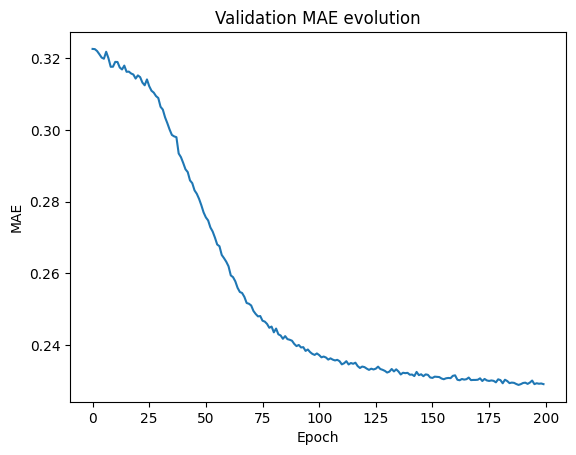

In [583]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Validation MAE evolution")
plt.show()

In [584]:
data = next(iter_test_loader)
X = (mx.array(data['X'].mT.numpy()), 
                mx.array(np.expand_dims(data['diff_p_s'].numpy(), 1)))
y, y_hat = np.stack([data['x'], data['y']], axis=-1)*MAX_DISTANCE, np.array(model(X), copy=False)*MAX_DISTANCE

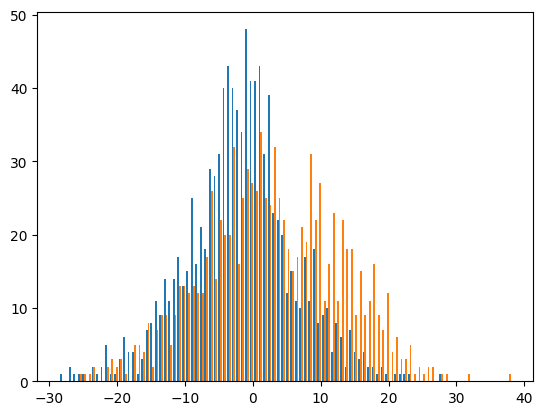

In [585]:
plt.hist(np.array(y_hat, copy=False), bins=100)
plt.show()

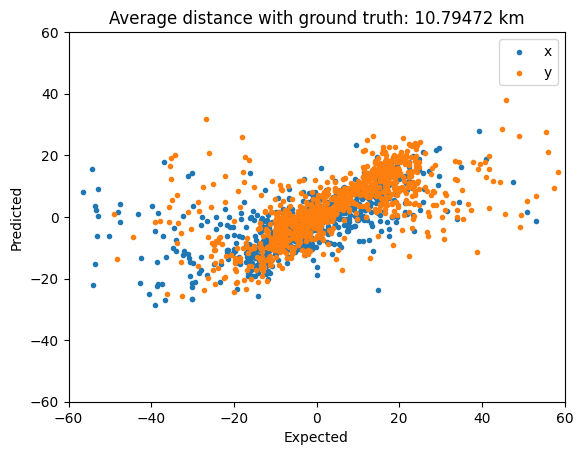

In [586]:
plt.scatter(y[:, 0], y_hat[:, 0], marker='.')
plt.scatter(y[:, 1], y_hat[:, 1], marker='.')
plt.xlim(-60, 60)
plt.ylim(-60, 60)
plt.legend(["x", "y"])
plt.xlabel("Expected")
plt.ylabel("Predicted")
plt.title(f"Average distance with ground truth: %.5f km"%np.mean((((y[:, 0]-y_hat[:, 0])**2) + ((y[:, 1]-y_hat[:, 1])**2))**0.5))
plt.show()

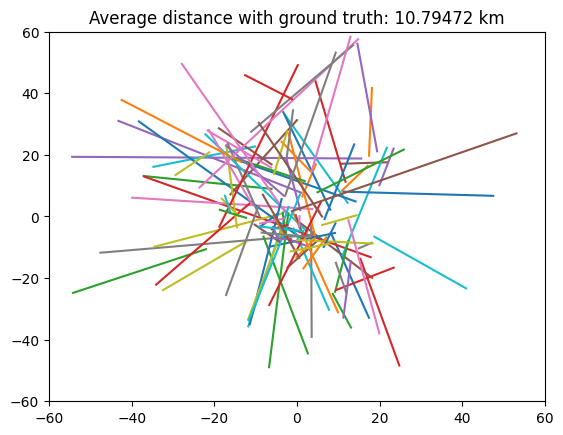

In [588]:
for i in range(100):
    plt.plot([y[i, 0], y_hat[i, 0]], [y[i, 1], y_hat[i, 1]])
plt.xlim(-60, 60)
plt.ylim(-60, 60)
plt.title(f"Average distance with ground truth: %.5f km"%np.mean((((y[:, 0]-y_hat[:, 0])**2) + ((y[:, 1]-y_hat[:, 1])**2))**0.5))
plt.show()